The Gurugram-based company ‘FlipItNews’ aims to revolutionize the way Indians perceive finance, business, and capital market investment, by giving it a boost through artificial intelligence (AI) and machine learning (ML). They’re on a mission to reinvent financial literacy for Indians, where financial awareness is driven by smart information discovery and engagement with peers. Through their smart content discovery and contextual engagement, the company is simplifying business, finance, and investment for millennials and first-time investors

The goal of this project is to use a bunch of news articles extracted from the companies’ internal database and categorize them into several categories like politics, technology, sports, business and entertainment based on their content. Use natural language processing and create & compare at least three different models.

### Loading libraries

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import re
import string
import gensim
import gensim.downloader as api
import spacy
import contractions

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

### Reading Dataset

In [4]:
tqdm.pandas()

In [5]:
df = pd.read_csv('nlp1.csv')
df.head()

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...


### Exploring dataset

In [6]:
df.shape

(2225, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Article   2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [8]:
#no null values! that's great

In [9]:
df['Category'].value_counts()

Sports           511
Business         510
Politics         417
Technology       401
Entertainment    386
Name: Category, dtype: int64

In [10]:
# it is fairly balanced only! let's proceed

In [11]:
# let's convert the categorical data to numeric

In [22]:
def convert(x):
    if x == 'Sports':
        return 1
    elif x == 'Business':
        return 2
    elif x == 'Politics':
        return 3
    elif x == 'Technology':
        return 4
    elif x == 'Entertainment':
        return 5
    else:
        try:
            raise Exception()
        except Exception as ce:
            print(f"There is an error")

In [24]:
df['Category_num'] = df['Category'].progress_apply(convert)

100%|███████████████████████████████████| 2225/2225 [00:00<00:00, 499295.19it/s]


In [25]:
df.head()

,Category,Article,Category_num
0,Technology,tv future in the hands of viewers with home th...,4
1,Business,worldcom boss left books alone former worldc...,2
2,Sports,tigers wary of farrell gamble leicester say ...,1
3,Sports,yeading face newcastle in fa cup premiership s...,1
4,Entertainment,ocean s twelve raids box office ocean s twelve...,5


In [33]:
df['Article'] = df['Article'].astype('str')

In [26]:
df['Category_num'].value_counts()

1    511
2    510
3    417
4    401
5    386
Name: Category_num, dtype: int64

In [27]:
# all seems good! now let's focus on Article columns

In [36]:
nlp = spacy.load('en_core_web_lg')

In [84]:
def preprocess(text):
    
    text = contractions.fix(text.lower()) # to remove any contractions present in the text
    doc = nlp(text)

    results = []
    
    for token in doc:
        if token.is_punct or token.is_stop:  #removing punctuations and removing stopwords
            continue
        results.append(token.lemma_)  #applying lemmatization
    
    results = " ".join(results)
    
    results = re.sub(" \w{1} ", " ", results) # removing any single character word
    
    results = re.sub("\s\s+", " ", results)
    
    return results
    

#### Lemmatization is a more gramatical oriented. It will supply the root word of a token. Stemming is like a hard-core rule based technique. It can result in meaningless words. I am preferring to use Lemmatization here.

##### One may ask why lemmatization here? 

#### Well, the task is classification. It is assumed that each class will have their own respective unique words. Like for e.g. Entertainment class might include specific words like box office. so if we can compare based on words which class is there, i should use the simplest form of word - i.e. it's root word

In [67]:
#creating the new column

In [85]:
df['Article_new'] = df['Article'].progress_apply(preprocess)

100%|███████████████████████████████████████| 2225/2225 [02:29<00:00, 14.85it/s]


In [86]:
df.head()

,Category,Article,Category_num,Article_new
0,Technology,tv future in the hands of viewers with home th...,4,tv future hand viewer home theatre system plas...
1,Business,worldcom boss left books alone former worldc...,2,worldcom boss leave book worldcom boss bernie ...
2,Sports,tigers wary of farrell gamble leicester say ...,1,tiger wary farrell gamble leicester rush make ...
3,Sports,yeading face newcastle in fa cup premiership s...,1,yeade face newcastle fa cup premiership newcas...
4,Entertainment,ocean s twelve raids box office ocean s twelve...,5,ocean raid box office ocean crime caper sequel...


#### Let's see the results

In [87]:
df['Article'][80]

'us company admits benin bribery a us defence and telecommunications company has agreed to pay $28.5m after admitting bribery in the west african state of benin.  the titan corporation was accused of funnelling more than $2m into the 2001 re-election campaign of president mathieu kerekou. at the time  titan was trying to get a higher price for a telecommunications project in benin. there is no suggestion that mr kerekou was himself aware of any wrongdoing. titan  a california-based company  pleaded guilty to falsifying its accounts and violating us anti-bribery laws. it agreed to pay $13m in criminal penalties  as well as $15.5m to settle a civil lawsuit brought by the us financial watchdog  the securities and exchange commission (sec).  the sec had accused titan of illegally paying $2.1m to an unnamed agent in benin claiming ties with president kerekou. some of the money was used to pay for t-shirts with campaign slogans on them ahead of the 2001 election. shortly after the poll  whic

In [88]:
df['Article_new'][80]

'company admit benin bribery defence telecommunication company agree pay $ 28.5 admit bribery west african state benin titan corporation accuse funnel $ m 2001 election campaign president mathieu kerekou time titan try high price telecommunications project benin suggestion mr kerekou aware wrongdoing titan california base company plead guilty falsify account violate anti bribery law agree pay $ 13 criminal penalty $ 15.5 settle civil lawsuit bring financial watchdog security exchange commission sec sec accuse titan illegally pay $ 2.1 unnamed agent benin claim tie president kerekou money pay shirt campaign slogan ahead 2001 election shortly poll mr kerekou win benin official agree quadruple titan management fee prosecute attorney carol lam say company note attempt bribe foreign official criminal conduct appropriately prosecute company say long tolerate practice foreign corrupt practice act crime american firm bribe foreign official'

In [89]:
# term 'us' is gone because it was like that in data itself. so when i removed stopwords, it was also removed :(

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df['Article_new'], df['Category_num'],
                                                    test_size= 0.25, stratify= df['Category_num'],
                                                    random_state= 505)

In [93]:
X_train.shape, X_test.shape

((1668,), (557,))

In [96]:
X_train = X_train.values
X_test = X_test.values

### Model Building

In [97]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

#### DecisionTree

              precision    recall  f1-score   support

           1       0.83      0.88      0.86       128
           2       0.73      0.80      0.76       128
           3       0.78      0.76      0.77       104
           4       0.91      0.84      0.87       100
           5       0.85      0.78      0.82        97

    accuracy                           0.82       557
   macro avg       0.82      0.81      0.82       557
weighted avg       0.82      0.82      0.82       557



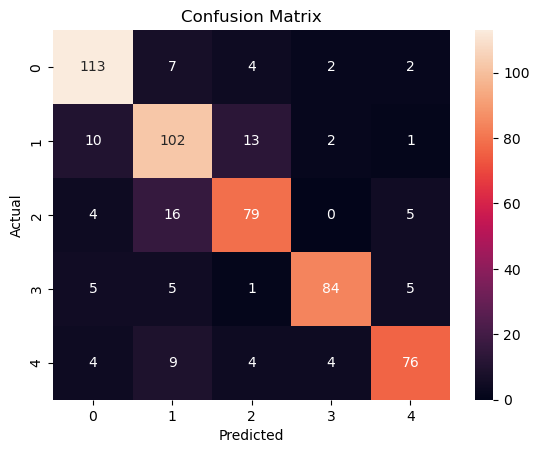

In [107]:
pipe1 = Pipeline([
    ('first', CountVectorizer()),
    ('second', DecisionTreeClassifier(random_state = 500, class_weight='balanced'))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

              precision    recall  f1-score   support

           1       0.86      0.90      0.88       128
           2       0.74      0.77      0.76       128
           3       0.73      0.73      0.73       104
           4       0.87      0.82      0.85       100
           5       0.80      0.75      0.78        97

    accuracy                           0.80       557
   macro avg       0.80      0.80      0.80       557
weighted avg       0.80      0.80      0.80       557



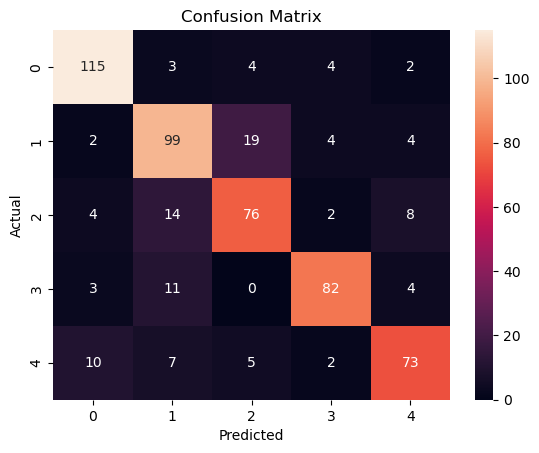

In [108]:
pipe1 = Pipeline([
    ('first', TfidfVectorizer()),
    ('second', DecisionTreeClassifier(random_state = 500, class_weight='balanced'))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### KNN

              precision    recall  f1-score   support

           1       0.43      1.00      0.60       128
           2       0.89      0.52      0.66       128
           3       0.92      0.67      0.78       104
           4       0.98      0.65      0.78       100
           5       0.95      0.41      0.58        97

    accuracy                           0.66       557
   macro avg       0.84      0.65      0.68       557
weighted avg       0.82      0.66      0.68       557



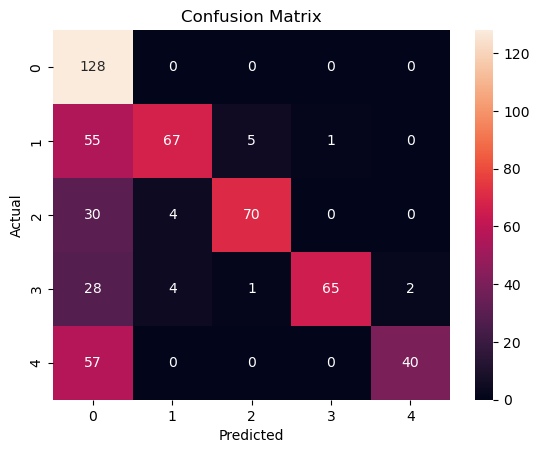

In [111]:
pipe1 = Pipeline([
    ('first', CountVectorizer()),
    ('second', KNeighborsClassifier(weights='distance'))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

              precision    recall  f1-score   support

           1       0.96      0.98      0.97       128
           2       0.95      0.89      0.92       128
           3       0.86      0.92      0.89       104
           4       0.91      0.97      0.94       100
           5       0.96      0.88      0.91        97

    accuracy                           0.93       557
   macro avg       0.93      0.93      0.93       557
weighted avg       0.93      0.93      0.93       557



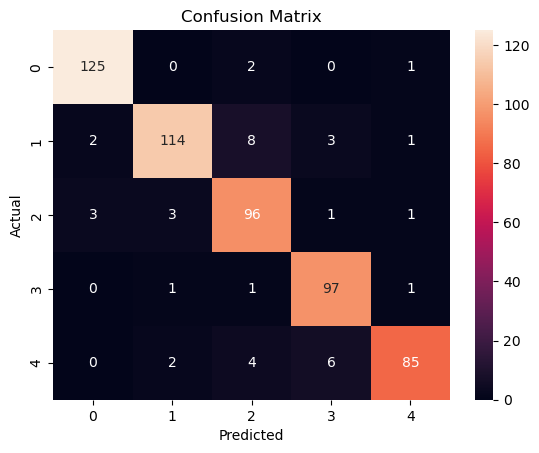

In [112]:
pipe1 = Pipeline([
    ('first', TfidfVectorizer()),
    ('second', KNeighborsClassifier(weights='distance'))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### RandomForest

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       128
           2       0.94      0.98      0.96       128
           3       0.96      0.96      0.96       104
           4       0.97      0.93      0.95       100
           5       0.96      0.91      0.93        97

    accuracy                           0.96       557
   macro avg       0.96      0.96      0.96       557
weighted avg       0.96      0.96      0.96       557



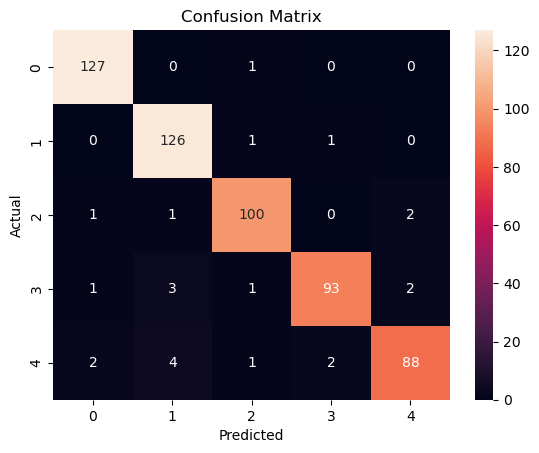

In [115]:
pipe1 = Pipeline([
    ('first', CountVectorizer()),
    ('second', RandomForestClassifier(class_weight='balanced', random_state=500))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       128
           2       0.91      0.98      0.95       128
           3       0.95      0.97      0.96       104
           4       0.99      0.93      0.96       100
           5       0.99      0.91      0.95        97

    accuracy                           0.96       557
   macro avg       0.96      0.96      0.96       557
weighted avg       0.96      0.96      0.96       557



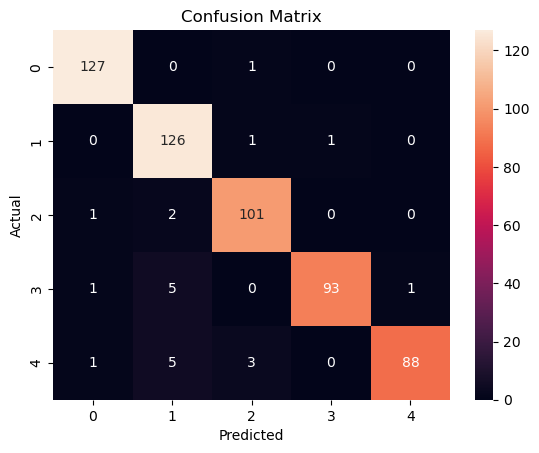

In [116]:
pipe1 = Pipeline([
    ('first', TfidfVectorizer()),
    ('second', RandomForestClassifier(class_weight='balanced', random_state=500))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Multinomial Naive Bayes

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       128
           2       0.99      0.96      0.98       128
           3       0.95      0.99      0.97       104
           4       0.93      1.00      0.97       100
           5       1.00      0.94      0.97        97

    accuracy                           0.98       557
   macro avg       0.98      0.98      0.98       557
weighted avg       0.98      0.98      0.98       557



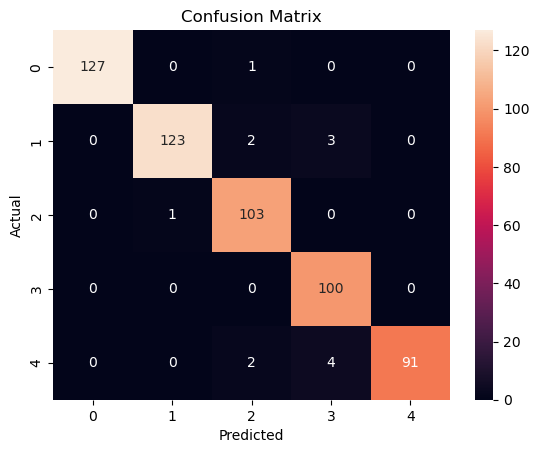

In [118]:
pipe1 = Pipeline([
    ('first', CountVectorizer()),
    ('second', MultinomialNB())
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       128
           2       0.93      0.98      0.95       128
           3       0.94      0.98      0.96       104
           4       0.96      0.95      0.95       100
           5       1.00      0.89      0.94        97

    accuracy                           0.96       557
   macro avg       0.96      0.96      0.96       557
weighted avg       0.96      0.96      0.96       557



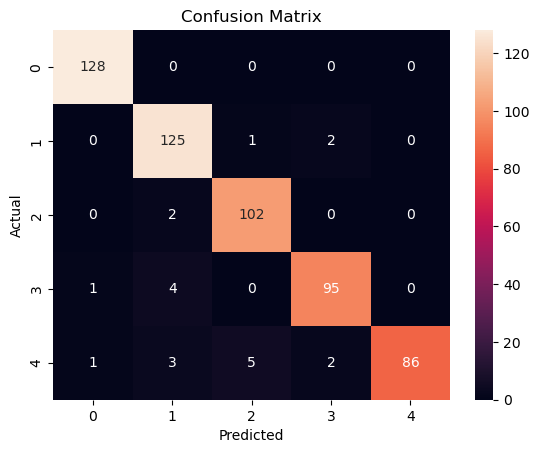

In [119]:
pipe1 = Pipeline([
    ('first', TfidfVectorizer()),
    ('second', MultinomialNB())
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Conclusion:

    1) DecisionTree had poor performance due to being overfitted on the data.
    2) KNN with TfidfVectorizer gave exceptional performance.
    3) RandomForest as usual - phenomenal performance
    4) Multinomial NaiveBayes worked best and gave best performance with COUNTVECTORIZER

# Other steps: Lets vectorize it

In [42]:
embeder1 = api.load('word2vec-google-news-300') # 300 dimensional size

In [ ]:
embeder2 = api.load('glove-wiki-gigaword-300') # 300 dimensional size

In [120]:
embeder3 = SentenceTransformer('paraphrase-MiniLM-L6-v2') # 384 dimensional size


For this usecase i will use embeder 3

In [127]:
def preprocess_to_vector(text):
    
    vector = embeder3.encode(text)
    
    return vector
    
    

In [128]:
df['vector'] = df['Article_new'].progress_apply(preprocess_to_vector)

100%|███████████████████████████████████████| 2225/2225 [00:27<00:00, 81.01it/s]


In [136]:
X = df['vector'].values
X = np.stack(X)

y = df['Category_num']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y,
                                                    test_size= 0.25, stratify= y,
                                                    random_state= 505)

              precision    recall  f1-score   support

           1       0.97      0.96      0.96       128
           2       0.92      0.92      0.92       128
           3       0.91      0.92      0.92       104
           4       0.89      0.92      0.91       100
           5       0.95      0.92      0.93        97

    accuracy                           0.93       557
   macro avg       0.93      0.93      0.93       557
weighted avg       0.93      0.93      0.93       557



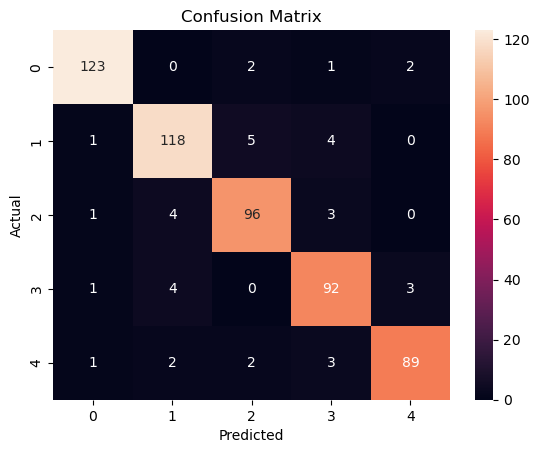

In [145]:
pipe1 = Pipeline([
    ('first', MinMaxScaler()),
    ('second', MultinomialNB())
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       128
           2       0.90      0.93      0.92       128
           3       0.89      0.91      0.90       104
           4       0.94      0.95      0.95       100
           5       0.98      0.87      0.92        97

    accuracy                           0.93       557
   macro avg       0.93      0.93      0.93       557
weighted avg       0.93      0.93      0.93       557



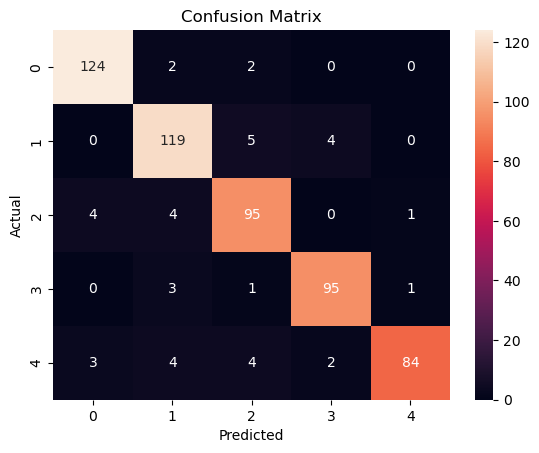

In [149]:
pipe1 = Pipeline([
    ('second', RandomForestClassifier(random_state= 500, class_weight='balanced'))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       128
           2       0.95      0.88      0.91       128
           3       0.88      0.95      0.92       104
           4       0.91      0.98      0.94       100
           5       0.99      0.90      0.94        97

    accuracy                           0.94       557
   macro avg       0.94      0.94      0.94       557
weighted avg       0.94      0.94      0.94       557



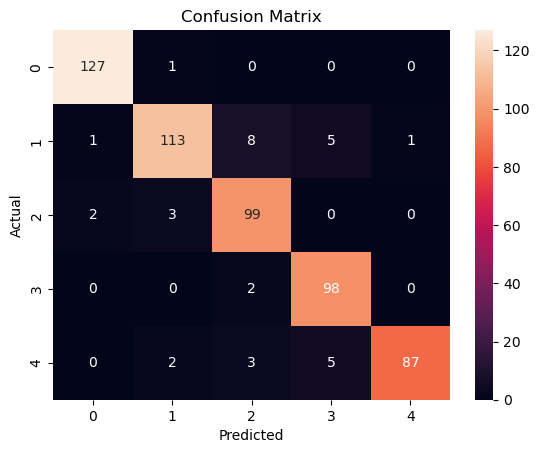

In [150]:
pipe1 = Pipeline([
    ('second', KNeighborsClassifier(weights='distance'))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

              precision    recall  f1-score   support

           1       0.70      0.78      0.74       128
           2       0.68      0.61      0.64       128
           3       0.70      0.71      0.71       104
           4       0.73      0.71      0.72       100
           5       0.56      0.57      0.56        97

    accuracy                           0.68       557
   macro avg       0.68      0.68      0.68       557
weighted avg       0.68      0.68      0.68       557



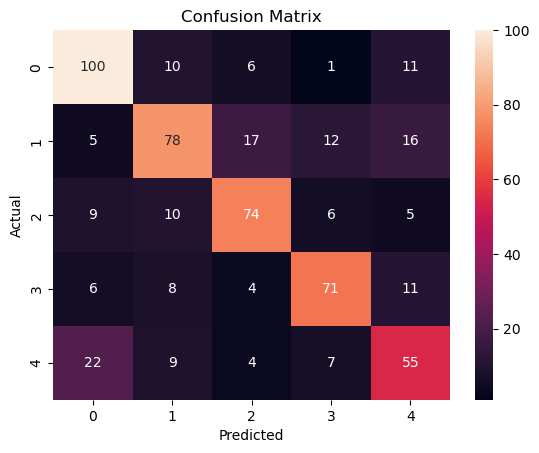

In [151]:
pipe1 = Pipeline([
    ('second', DecisionTreeClassifier(class_weight='balanced'))
])

pipe1.fit(X_train,y_train)
pred1 = pipe1.predict(X_test)
cm = confusion_matrix(y_test, pred1)

print(classification_report(y_test,pred1))

sbn.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Conclusion 2: 

1) DecisionTree was having poor performance
2) RandomForest, Multinomial NB and KNN gave best performance

# Thanks :)